**GENERAL INFORMATION**

Further Reading:

https://www.zotero.org/michael.otto/collections/4MM7QXCZ

https://maartengr.github.io/BERTopic/index.html



**DEPENDENCIES**

In [1]:
%%capture
!pip install bertopic datasets openai datamapplot

In [2]:
!pip install --upgrade datasets fsspec aiohttp

In [3]:
!pip install stopwordsiso

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 6.7 MB/s eta 0:00:00


**IMPORTS**

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from google.colab import drive
from IPython.display import display
from umap import UMAP
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from copy import deepcopy
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
import stopwordsiso as stopwords
from collections import defaultdict
import openai
from openai import OpenAI
from bertopic.representation import OpenAI as OpenAIRep
import matplotlib.pyplot as plt


drive.mount('/content/drive') # only for google colab

/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Mounted at /content/drive


**DATA ACQUISISTION**

In [5]:
def load_and_validate_csv(file_path):
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded. Here are the first rows:")
        display(df.head())
    except FileNotFoundError:
        raise FileNotFoundError(f"No file found at {file_path!r}. Check that the path is correct.")
    except Exception as e:
        raise RuntimeError(f"Error reading {file_path!r}: {e}")

    required_cols = ['pid', 'text']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise KeyError(f"Missing columns in CSV: {missing}")
    df_par = df.copy()

    return df, df_par

In [6]:
def prepare_text_data(df_par):
    df_par = df_par.dropna(subset=['text'])
    df_par['text'] = df_par['text'].astype(str)

    pids = df_par['pid'].tolist()
    texts = df_par['text'].tolist()
    langs = df_par['language'].dropna().unique().tolist()

    print(f" First 5 pids: {pids[:5]}")
    print(f"First 5 texts: {texts[:5]}")
    print(f"First 5 launguages: {langs[:5]}")

    return pids, texts, langs

**EMBEDDING**

Start of by transforming the input texts into numerical represantation. Turns the documents into an n-dimensionary array.

Further Reading:

https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html

In [7]:
def embed_docs(texts):
    model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')##thenlper/gte-small
    # Clean input of floats
    texts = [str(t) for t in texts if isinstance(t, str) and t.strip() != ""]

    embeddings = model.encode(texts, show_progress_bar=True)
    print("Embedding complete. Shape:", embeddings.shape)
    return model, embeddings

**DIMENSIONALITY REDUCTION**

Now the embeddings have high dimensionality, which might hinder clustering later on the embeddings are reduced to a workable dimensional space, such as 5 dimensions.

Further Reading:

https://www.zotero.org/michael.otto/collections/WEQ9TCUX

https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html


*UMAP*

In [8]:
def reduce_dimensions(embeddings):

    umap_model = UMAP(
      n_components=5, #number of dimensions
      n_neighbors=10,
      metric='cosine',
      random_state=42
    )
    reduced_embeddings = umap_model.fit_transform(embeddings)

    return reduced_embeddings, umap_model


*PCA (Alternative)*

In [9]:

def reduce_dimensions_pca(embeddings, n_components=50):
    with tqdm(total=1, desc="PCA reduction", unit="step") as pbar:
        pca_model = PCA(
            n_components=n_components, #number of dimensions
            random_state=42
        )
        reduced_embeddings = pca_model.fit_transform(embeddings)
        pbar.update(1)

    return reduced_embeddings, pca_model

**CLUSTERING**

The input embeddings ar now clustered into groups of similar embeddings which allows the model to extract the topics.

Further Reading:

https://www.zotero.org/michael.otto/collections/3PKFGDVB

https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html

*HDBScan*

In [10]:
def cluster_embeddings_hdb(reduced_embeddings):
  hdbscan_model = HDBSCAN(
      min_cluster_size=15, #minimal amount of tokens in a cluster
      min_samples=10,
      metric='euclidean', #metric for measuring distance between points
      cluster_selection_method='eom',
      prediction_data=True
  ).fit(reduced_embeddings)

  clusters = hdbscan_model.labels_

  n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
  print(f"Total clusters (excluding noise): {n_clusters}")


  n_noise = np.sum(clusters == -1)
  print(f"Noise points: {n_noise} ({n_noise / len(clusters):.1%} of all paragraphs)")

  cluster_sizes = pd.Series(clusters).value_counts().sort_values(ascending=False)
  print("\nTop 10 cluster sizes (cluster_id: size):")
  print(cluster_sizes.head(10))

  print("\nSmallest 10 non-noise cluster sizes:")
  print(cluster_sizes[cluster_sizes.index != -1].tail(10))

  return clusters, hdbscan_model

*k-means* (Alternative)

In [11]:
def cluster_embeddings_kmeans(reduced_embeddings):
    n_clusters = 50
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced_embeddings)

    print(f"Total clusters: {n_clusters}")
    cluster_sizes = pd.Series(clusters).value_counts().sort_values(ascending=False)

    print("\nTop 10 cluster sizes (cluster_id: size):")
    print(cluster_sizes.head(10))

    print("\nSmallest 10 cluster sizes:")
    print(cluster_sizes.tail(10))

    return clusters, kmeans

*Inspect a Cluster*

In [12]:
def inspection(clusters, texts):
  cluster = 3
  for index in np.where(clusters==cluster)[0][:3]:
      print(texts[index][:300] + "... \n")

*Reduce Embeddings for Plotting*

In [13]:
def reduce_st_plot_embeds(embeddings):
  reduced_embeddings = UMAP(
      n_components=2, min_dist=0.0, metric='cosine', random_state=42 #reduce to 2 dimensions to enable plotting
  ).fit_transform(embeddings)
  return reduced_embeddings

*Static plot for the cluster*

In [14]:
def static_plot(clusters, texts, reduced_embeddings, save_path=None):
    df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
    df["cluster"] = [str(c) for c in clusters]

    clusters_df = df[df["cluster"] != "-1"]
    outliers_df = df[df["cluster"] == "-1"]

    plt.figure(figsize=(10, 8))

    # Plot outliers
    plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey", label="Noise")

    # Plot clusters
    scatter = plt.scatter(
        clusters_df.x, clusters_df.y,
        c=clusters_df.cluster.astype(int),
        alpha=0.6, s=2, cmap='tab20b', label="Clusters"
    )

    plt.axis('off')

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()
    plt.close()

*Training the model*

In [15]:
def train_model(texts, embeddings):
    topic_model = BERTopic(
        embedding_model = model,
        #embedding_model=SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2'), # Use the SentenceTransformer model directly for pca
        umap_model=umap_model,
        #optional
        #umap_model = pca_model, #alternative to the umap model, for usage do not forget to also change it in the pipeline
        hdbscan_model=hdbscan_model,
        #hdbscan_model=kmeans, #alternative to the hdbscan model, for usage do not forget to also change it in the pipeline
        language="multilingual",
        verbose=True
    )

    topics, probs = topic_model.fit_transform(texts, embeddings)

    return topic_model, topics, probs

*Align Dataframe*

In [16]:
def align_df_par(df_par, topics, probs):
  df_par_aligned = df_par.loc[[i for i, t in enumerate(texts) if isinstance(t, str) and t.strip() != ""]].copy()

  df_par_aligned['pred_topic'] = topics
  df_par_aligned['pred_prob']  = probs   # probs is already one float per row
  df_par = df_par_aligned
  return df_par

**VECTORIZERS**

Allows for interpretable topic represantations.

Further Reading:

https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html

https://www.zotero.org/michael.otto/collections/368TFPZM


https://github.com/stopwords-iso/stopwords-iso


*Count Vectorizer*

In [ ]:
def adjust_stop_words(topic_model, texts, langs):
  stop_words = ["et", "in", "est", "ad", "qui", "autem", "non", "de", "eius", "ut", "quae", "cum", "si", "eum"]
  stop_words = set()

  sw = set()
  #stopwordsiso is a ell amintained library following the ISO 639-1 language code, available languages can be displyed with stopwords.langs()
  for lang in langs:
    if isinstance(lang, str) and stopwords.has_lang(lang):
      sw.update(stopwords.stopwords(lang))

  stop_words = list(sw)
  #stop_words = list(stop_words)

  vectorizer_model = CountVectorizer(stop_words=stop_words)
  topic_model.update_topics(texts, vectorizer_model=vectorizer_model)
  return stop_words

*Topic Infos*

In [18]:
def topic_infos(topic_model):
  print(topic_model.get_topic_info())
  print(topic_model.find_topics("baskisch"))
  print(topic_model.get_topic(0))
  print(topic_model.get_topic(24))


*Build dataframe*

In [19]:
def snapshot_topics_df(df_par, texts, topics, probs, topic_model, *,
                       n_words=5, combine_sections=False):
    # keep only non-empty text rows and align arrays
    mask = [isinstance(t, str) and t.strip() != "" for t in texts]
    df = df_par.loc[mask].copy()
    f_topics = [t for t, keep in zip(topics, mask) if keep]
    f_probs  = [p for p, keep in zip(probs,  mask) if keep]

    def top_words(tid, k=n_words):
        words = topic_model.get_topic(tid) or []
        return ", ".join([w for w, _ in words[:k]]) if words else None

    df["pred_topic"] = f_topics
    df["pred_prob"]  = f_probs
    df["topic_top_words"] = df["pred_topic"].map(lambda t: top_words(t, n_words))

    if combine_sections:
        df = combine_letter_sections_append_topics(
            df,
            id_col="pid",
            text_col="text",
            topic_col="pred_topic",
            prob_col="pred_prob",
            lang_col="language",
        )
    return df

In [20]:
def combine_letter_sections_append_topics( #recombines the split sections form the preprocessing
    df,
    id_col="pid",
    text_col="text",
    topic_col="pred_topic",
    prob_col="pred_prob",
    lang_col="language",
):
    df = df.copy()

    # Regex L.<letter>-<para>-<section>
    pat = re.compile(r"^L\.([^-]+)-([^-]+)-([^-]+)$")
    sect_mask = df[id_col].astype(str).str.match(pat)

    if not sect_mask.any():
        return df

    sections = df.loc[sect_mask].copy()

    parent_ids, section_idxs = [], []
    for pid in sections[id_col].astype(str):
        m = pat.match(pid)
        letter, para, sec = m.group(1), m.group(2), m.group(3)
        try:
            sec_i = int(sec)
        except Exception:
            sec_i = float("inf")
        parent_ids.append(f".{letter}-{para}")
        section_idxs.append(sec_i)

    sections["_parent_id"] = parent_ids
    sections["_section_idx"] = section_idxs

    df_no_sections = df.loc[~sect_mask].copy()
    agg_rows = []

    for parent_id, g in sections.sort_values("_section_idx").groupby("_parent_id"):
        combined_text = " ".join([str(t) for t in g[text_col] if pd.notna(t) and str(t).strip()])

        combined_topics = ", ".join([str(t) for t in g[topic_col] if pd.notna(t)])

        combined_probs = ", ".join([str(p) for p in g[prob_col] if pd.notna(p)])

        lang = None
        if lang_col in g:
            mode_lang = g[lang_col].mode(dropna=True)
            lang = mode_lang.iloc[0] if not mode_lang.empty else None

        if (df_no_sections[id_col] == parent_id).any():
            base_idx = df_no_sections.index[df_no_sections[id_col] == parent_id][0]
            df_no_sections.at[base_idx, text_col] = (
                (str(df_no_sections.at[base_idx, text_col]) + " " + combined_text).strip()
            )
            df_no_sections.at[base_idx, topic_col] = (
                (str(df_no_sections.at[base_idx, topic_col]) + ", " + combined_topics).strip(", ")
            )
            df_no_sections.at[base_idx, prob_col] = (
                (str(df_no_sections.at[base_idx, prob_col]) + ", " + combined_probs).strip(", ")
            )
            if lang_col in df_no_sections.columns and lang is not None:
                df_no_sections.at[base_idx, lang_col] = lang
        else:
            first = g.iloc[0].to_dict()
            new_row = {col: None for col in df.columns}
            new_row.update(first)
            new_row[id_col] = parent_id
            new_row[text_col] = combined_text
            new_row[topic_col] = combined_topics
            new_row[prob_col] = combined_probs
            if lang_col in new_row and lang is not None:
                new_row[lang_col] = lang
            agg_rows.append(new_row)

    if agg_rows:
        df_no_sections = pd.concat([df_no_sections, pd.DataFrame(agg_rows)], ignore_index=True)

    return df_no_sections

*Visualisation of topics*

In [21]:
def visualize_topics(topic_infos, texts, reduced_embeddings):

  # Visualize barchart with ranked keywords
  topic_infos.visualize_barchart().show()

  # Visualize relationships between topics
  topic_infos.visualize_heatmap(n_clusters=15).show()

  # Visualize the potential hierarchical structure of topics
  topic_infos.visualize_hierarchy().show()

**FINETUNING**

Can further extract the semantic relationship between words by using a multitude of representation models.

Further Reading:

https://maartengr.github.io/BERTopic/getting_started/representation/representation.html

https://www.zotero.org/michael.otto/collections/KRFUSVYB


*Representation Models*

In [22]:
def topic_differences(original_topics, updated_topics, nr_topics=5):
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):
        og_words = " ".join(list(zip(*original_topics[topic]))[0][:3])
        new_words = " ".join(list(zip(*updated_topics[topic]))[0][:3])
        df.loc[len(df)] = [topic, og_words, new_words]
    return df


*KeyBERTInspired*

In [23]:
def keybert_topic_diffs(topic_model, original_topics, texts):
  representation_model = KeyBERTInspired()
  topic_model.update_topics(texts, representation_model=representation_model)
  updated_topics = topic_model.topic_representations_
  diff_df = topic_differences(original_topics, updated_topics, nr_topics=15)

  return diff_df, updated_topics

*Maximal Marginal Relevance*

In [24]:
def max_marg_rel(topic_model, texts, original_topics, nr_topics=5):
    mmr = MaximalMarginalRelevance(diversity=0.5)

    topic_model.update_topics(
        texts,
        representation_model=mmr         # swap in MMR
    )
    updated_topics_mmr = topic_model.topic_representations_
    diff_df = topic_differences(original_topics, updated_topics_mmr, nr_topics=nr_topics)

    return diff_df, updated_topics_mmr

**MAIN PIPELINE**

Dataset loaded. Here are the first rows:


,source_file,pid,sender_id,sender,receiver_id,receiver,date,text,language,keywords,word_count
0,hsa.letter.1.xml,L.1-1,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Ma Doudou vous envoie une petite brochure jaun...,fr,NaN,17
1,hsa.letter.1.xml,L.1-2,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Nous sommes anxieux l’un et l’autre d’avoir de...,fr,NaN,31
2,hsa.letter.3.xml,L.3-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Bereits 5 Tage nach Abgang meines letzten Brie...,de,Revue de Linguistique Romane,124
3,hsa.letter.3.xml,L.3-2-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,"Was die deutsche Verlagswelt angeht, so muss i...",de,Revue de Linguistique Romane,511
4,hsa.letter.3.xml,L.3-2-2,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,"sicherlich viel verdankt— erklärt, er wolle di...",de,Revue de Linguistique Romane,46


 First 5 pids: ['L.1-1', 'L.1-2', 'L.3-1', 'L.3-2-1', 'L.3-2-2']
First 5 texts: ['Ma Doudou vous envoie une petite brochure jaune à laquelle vous ferez bon accueil, j’en suis sûr.', 'Nous sommes anxieux l’un et l’autre d’avoir de vos nouvelles, et voudrions bien savoir que ce sont vos travaux, et non la maladie, qui nous privent de toute lettre de vous.', 'Bereits 5 Tage nach Abgang meines letzten Briefes an Sie erhielt ich Ihre Antwort und bald darauf Ihre Druckschriften, für die ich Ihnen vielmals danke. Ich wollte Ihnen nun erst antworten, nachdem ich diese durchgearbeitet hatte, um Ihnen gleich meine Zweifel und Bemerkungen dazu mitzuteilen, doch da sie eine mühelose Fundgrube für meine Etymologien = Zusammenstellungen bilden und das Semester bald beginnt, wollte ich meine letzten Ferientage der Erledigung schwierigerer Aufgaben widmen, besonders dem Durchsuchen der letzten Bände der Revue de ling. der Werke Luchaires u. ä. nach brauchbarem Stoff. Nun erhalte ich gerade zum Feste a

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1388 [00:00<?, ?it/s]

Embedding complete. Shape: (44405, 384)
Total clusters (excluding noise): 225
Noise points: 30452 (68.6% of all paragraphs)

Top 10 cluster sizes (cluster_id: size):
-1      30452
 57      1316
 88       525
 130      503
 152      280
 43       240
 115      237
 52       234
 207      221
 151      206
Name: count, dtype: int64

Smallest 10 non-noise cluster sizes:
199    16
45     16
54     16
136    16
92     15
188    15
137    15
116    15
125    15
202    15
Name: count, dtype: int64
M. Winkler me anuncia su visita para el próximo Julio. Ignoro sus planes: no sé si viene de paso ó si intenta dedicarse aquí á hacer algunas investigaciones.... 

El Dr. Winkler nos leyó gran parte de su trabajo, que es larguísimo, y luego nos lo entregó para su publicación en la revista. Ignoro la competencia que dicho señor pueda tener en uralo altaico, pero en todo caso la impresión que sacamos de su manera de argumentar no fué muy favorable. Me hizo el ef... 

No me choca que el Dr. Winkler no d

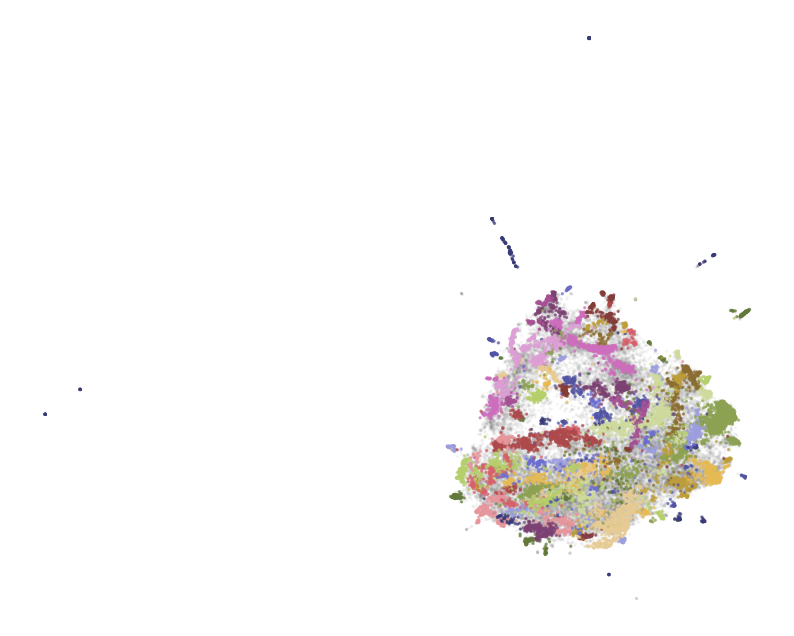

2025-09-10 07:16:17,896 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-09-10 07:17:14,646 - BERTopic - Dimensionality - Completed ✓
2025-09-10 07:17:14,649 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-09-10 07:17:20,115 - BERTopic - Cluster - Completed ✓
2025-09-10 07:17:20,129 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-09-10 07:17:23,164 - BERTopic - Representation - Completed ✓


     Topic  Count                                      Name  \
0       -1  30452                         -1_ich_die_der_in   
1        0   1316         0_basque_baskischen_baskische_the   
2        1    525                         1_el_madrid_en_de   
3        2    503             2_druckerei_bogen_werden_heft   
4        3    280                  3_wien_nach_leipzig_hier   
..     ...    ...                                       ...   
221    220     15                       220_149_144_160_157   
222    221     15              221_schuchardt_dr_prof_herrn   
223    222     15              222_band_heft_achträg_lichen   
224    223     15  223_vittoz_philippe_traduction_coulbeaux   
225    224     15                224_essere_iguk_biltze_adi   

                                        Representation  \
0    [ich, die, der, in, und, de, sie, zu, nicht, von]   
1    [basque, baskischen, baskische, the, of, to, b...   
2    [el, madrid, en, de, spanien, sevilla, que, lo...   
3    [druck

Batches:   0%|          | 0/1388 [00:00<?, ?it/s]

2025-09-10 07:19:05,478 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-09-10 07:19:05,611 - BERTopic - Dimensionality - Completed ✓
2025-09-10 07:19:05,615 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-09-10 07:19:09,144 - BERTopic - Cluster - Completed ✓


In [ ]:
file_path = ''  # ← adjust if needed
df, df_par = load_and_validate_csv(file_path)
pids, texts, langs = prepare_text_data(df_par)
model, embeddings = embed_docs(texts)
reduced_embeddings, umap_model = reduce_dimensions(embeddings)
#OPTIONAL (and only combined with k-means):
#reduced_embeddings, pca_model = reduce_dimensions_pca(embeddings)  #alternative to the umap model, for usage do not forget to also change it in the train_model function
clusters, hdbscan_model = cluster_embeddings_hdb(reduced_embeddings)
# OPTIONAL:
#clusters, kmeans = cluster_embeddings_kmeans(reduced_embeddings) #alternative to the hdbscan model, for usage do not forget to also change it in the train_model function
inspection(clusters, texts)
reduced_embeddings = reduce_st_plot_embeds(embeddings)
static_plot(clusters, texts, reduced_embeddings)
topic_model, topics, probs = train_model(texts, embeddings)
df_par = align_df_par(df_par, topics, probs)
topic_infos(topic_model)
vectorizer_model = adjust_stop_words(topic_model, texts, langs)
base_df = snapshot_topics_df(df_par, texts, topics, probs, topic_model,
                             n_words=5, combine_sections=True)

original_topics = deepcopy(topic_model.topic_representations_)

#explore different finetunig options
topic_model_keybert = deepcopy(topic_model)
topic_model_mmr     = deepcopy(topic_model)
topics_base, probs_base = topic_model.transform(texts)

diff_df, updated_topics_keybert = keybert_topic_diffs(topic_model_keybert, original_topics, texts)
df_keybert = snapshot_topics_df(df_par, texts, topics_base, probs_base, topic_model_keybert,
                                n_words=5, combine_sections=True)
#print(diff_df)

diff_df, updated_topics_mmr = max_marg_rel(topic_model_mmr, texts, original_topics)
df_mmr = snapshot_topics_df(df_par, texts, topics_base, probs_base, topic_model_mmr,
                            n_words=5, combine_sections=True)
#print(diff_df)

**Visualisation**

In [26]:
visualize_topics(topic_model, texts, reduced_embeddings)
visualize_topics(topic_model_keybert, texts, reduced_embeddings)
visualize_topics(topic_model_mmr, texts, reduced_embeddings)

In [27]:
base_df.head()


,source_file,pid,sender_id,sender,receiver_id,receiver,date,text,language,keywords,word_count,pred_topic,pred_prob,topic_top_words,_parent_id,_section_idx
0,hsa.letter.1.xml,L.1-1,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Ma Doudou vous envoie une petite brochure jaun...,fr,NaN,17,-1,0.0,"bitte, sagen, schreiben, lassen, arbeit",NaN,NaN
1,hsa.letter.1.xml,L.1-2,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Nous sommes anxieux l’un et l’autre d’avoir de...,fr,NaN,31,-1,0.0,"bitte, sagen, schreiben, lassen, arbeit",NaN,NaN
2,hsa.letter.3.xml,L.3-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Bereits 5 Tage nach Abgang meines letzten Brie...,de,Revue de Linguistique Romane,124,-1,0.0,"bitte, sagen, schreiben, lassen, arbeit",NaN,NaN
3,hsa.letter.3.xml,L.3-3,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Die Hauptschuld an diesen Zuständen tragen die...,de,Revue de Linguistique Romane,246,0,1.0,"basque, baskischen, baskische, basques, vinson",NaN,NaN
4,hsa.letter.3.xml,L.3-5,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Azkue klagte darüber dass der Arbeitseifer der...,de,Revue de Linguistique Romane,226,30,0.863949,"azkue, azkues, wörterbuch, dictionnaire, darri...",NaN,NaN


In [28]:
df_keybert.head()

,source_file,pid,sender_id,sender,receiver_id,receiver,date,text,language,keywords,word_count,pred_topic,pred_prob,topic_top_words,_parent_id,_section_idx
0,hsa.letter.1.xml,L.1-1,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Ma Doudou vous envoie une petite brochure jaun...,fr,NaN,17,-1,0.0,"doch, noch, du, wohl, haben",NaN,NaN
1,hsa.letter.1.xml,L.1-2,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Nous sommes anxieux l’un et l’autre d’avoir de...,fr,NaN,31,-1,0.0,"doch, noch, du, wohl, haben",NaN,NaN
2,hsa.letter.3.xml,L.3-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Bereits 5 Tage nach Abgang meines letzten Brie...,de,Revue de Linguistique Romane,124,-1,0.0,"doch, noch, du, wohl, haben",NaN,NaN
3,hsa.letter.3.xml,L.3-3,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Die Hauptschuld an diesen Zuständen tragen die...,de,Revue de Linguistique Romane,246,0,1.0,"baskische, baskischen, baskisch, basque, basques",NaN,NaN
4,hsa.letter.3.xml,L.3-5,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Azkue klagte darüber dass der Arbeitseifer der...,de,Revue de Linguistique Romane,226,30,0.863949,"azkue, azkues, dijo, azk, ihm",NaN,NaN


In [29]:
df_mmr.head()

,source_file,pid,sender_id,sender,receiver_id,receiver,date,text,language,keywords,word_count,pred_topic,pred_prob,topic_top_words,_parent_id,_section_idx
0,hsa.letter.1.xml,L.1-1,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Ma Doudou vous envoie une petite brochure jaun...,fr,NaN,17,-1,0.0,"die, nicht, auch, für, des",NaN,NaN
1,hsa.letter.1.xml,L.1-2,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Nous sommes anxieux l’un et l’autre d’avoir de...,fr,NaN,31,-1,0.0,"die, nicht, auch, für, des",NaN,NaN
2,hsa.letter.3.xml,L.3-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Bereits 5 Tage nach Abgang meines letzten Brie...,de,Revue de Linguistique Romane,124,-1,0.0,"die, nicht, auch, für, des",NaN,NaN
3,hsa.letter.3.xml,L.3-3,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Die Hauptschuld an diesen Zuständen tragen die...,de,Revue de Linguistique Romane,246,0,1.0,"basque, baskischen, baskische, basques, you",NaN,NaN
4,hsa.letter.3.xml,L.3-5,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Azkue klagte darüber dass der Arbeitseifer der...,de,Revue de Linguistique Romane,226,30,0.863949,"azkue, wörterbuch, diccionario, dictionnaire, ...",NaN,NaN


**Representation**

In [ ]:
client = OpenAI(api_key="") # insert openai api key here
rep = OpenAIRep(client, model="gpt-4o-mini", chat=True)
topic_model.update_topics(texts, representation_model=rep) # allows for creating labels that encompass the topic
df_llm = snapshot_topics_df(df_par, texts, topics, probs, topic_model, n_words=5,
                            combine_sections=True)

label_map = topic_model.topic_labels_
df_llm["topic_label"] = df_llm["pred_topic"].map(label_map)
df_llm.head()

100%|██████████| 226/226 [03:16<00:00,  1.15it/s]


,source_file,pid,sender_id,sender,receiver_id,receiver,date,text,language,keywords,word_count,pred_topic,pred_prob,topic_top_words,_parent_id,_section_idx,topic_label
0,hsa.letter.1.xml,L.1-1,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Ma Doudou vous envoie une petite brochure jaun...,fr,NaN,17,-1,0.0,Academic correspondence and challenges,NaN,NaN,-1_Academic correspondence and challenges
1,hsa.letter.1.xml,L.1-2,https://gams.uni-graz.at/o:hsa.persons#P.1069,Baissac,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1885-01-20,Nous sommes anxieux l’un et l’autre d’avoir de...,fr,NaN,31,-1,0.0,Academic correspondence and challenges,NaN,NaN,-1_Academic correspondence and challenges
2,hsa.letter.3.xml,L.3-1,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Bereits 5 Tage nach Abgang meines letzten Brie...,de,Revue de Linguistique Romane,124,-1,0.0,Academic correspondence and challenges,NaN,NaN,-1_Academic correspondence and challenges
3,hsa.letter.3.xml,L.3-3,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Die Hauptschuld an diesen Zuständen tragen die...,de,Revue de Linguistique Romane,246,0,1.0,Basque language studies,NaN,NaN,0_Basque language studies
4,hsa.letter.3.xml,L.3-5,https://gams.uni-graz.at/o:hsa.persons#P.1068,Bähr,https://gams.uni-graz.at/o:hsa.persons#P.109,Schuchardt,1924-04-22,Azkue klagte darüber dass der Arbeitseifer der...,de,Revue de Linguistique Romane,226,30,0.863949,Azkue and Linguistics,NaN,NaN,30_Azkue and Linguistics


In [32]:
unique_topics = sorted(df_llm["topic_top_words"].drop_duplicates())
print("\n".join(unique_topics))

Academia and Publishing Issues
Academic Associations Issues
Academic Correspondence Challenges
Academic Correspondence Disputes
Academic Correspondence Dynamics
Academic Correspondence Issues
Academic Institutions and Professorships
Academic Personnel
Academic Politics and Appointments
Academic and Political Struggles
Academic correspondence and challenges
Academic correspondence appreciation
Academic correspondence disputes
Academic disputes and appointments
Academic life and challenges
Address references
African languages research
Afrikaans language movement
Apology for disturbance
Appreciation and Acknowledgment
Appreciation for correspondence
Arab linguistics and culture
Azkue and Linguistics
Basque language studies
Berber linguistic studies
Beverages and digestion
Bibliothek und Dotation
Birthday wishes
Challenges in Linguistics
Chinese cultural imports
Chino-Russian Dialect
Comité de la Langue Universelle
Communication and Correspondence
Communication confusion
Communication misu

**Timeline**

In [33]:
def add_date_cols(df, date_col="date"):
    d = df.copy()
    year_only = d[date_col].astype(str).str.fullmatch(r"\d{4}")
    d["date_dt"] = pd.to_datetime(d[date_col], errors="coerce")
    d.loc[year_only, "date_dt"] = pd.to_datetime(d.loc[year_only, date_col] + "-01-01", errors="coerce")
    d["year"] = d["date_dt"].dt.year
    return d

In [34]:

def build_timeline(df, topic_col="topic_top_words", top_n=8, freq="Y"):
    """freq='Y' yearly, 'M' monthly (only rows with full dates contribute)."""
    d = df.dropna(subset=["date_dt", topic_col]).copy()
    top_topics = d[topic_col].value_counts().head(top_n).index
    top_topics = top_topics[3:] #enable this to leave out the most dominant topics
    d = d[d[topic_col].isin(top_topics)]
    ts = (d.set_index("date_dt")
            .groupby([pd.Grouper(freq=freq), topic_col]).size()
            .rename("count").reset_index())
    wide = ts.pivot(index="date_dt", columns=topic_col, values="count").fillna(0).sort_index()
    return wide

In [35]:
def plot_timeline(wide, title="Topics over Time"):
    if wide.empty:
        print("No data to plot.")
        return
    ax = wide.plot.area(figsize=(12, 6))
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("# Documents")
    ax.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

In [36]:
def to_percent(wide):
    share = wide.div(wide.sum(axis=1), axis=0).fillna(0) * 100
    return share

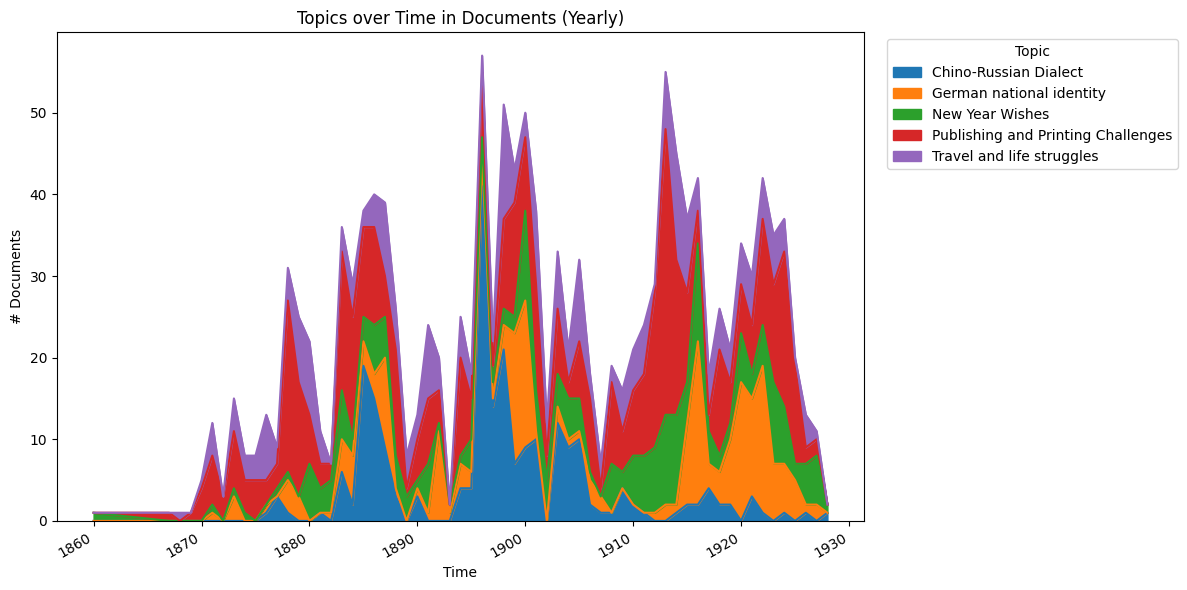

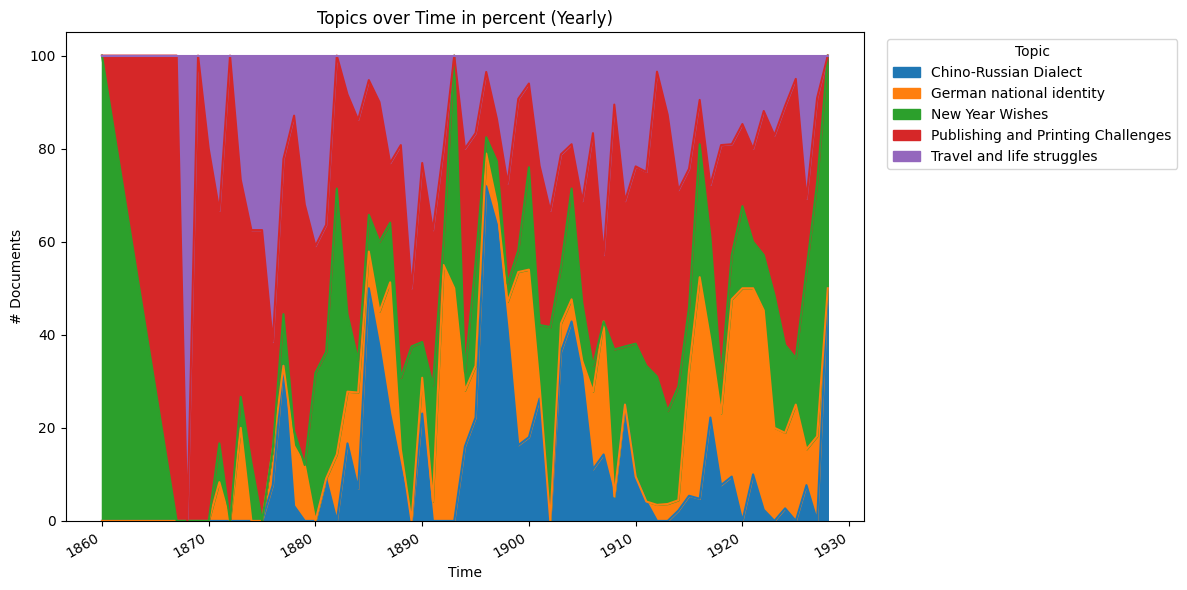

In [37]:
df_llm = add_date_cols(df_llm, date_col="date")
yearly = build_timeline(df_llm, topic_col="topic_top_words", top_n=8, freq="Y")
plot_timeline(yearly, title="Topics over Time in Documents (Yearly)")
yearly_percent = to_percent(yearly)
plot_timeline(yearly_percent, title="Topics over Time in percent (Yearly)")

In [ ]:
safe_path = '' # <- adjust if needed
df_llm.to_csv(safe_path)